In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import tqdm
import os
import re
import copy
import datetime
import numba
from numba import jit,prange

### Setup

In [2]:
infolder = "xavier/"

outfolder = "xavier_computed/"

temppref = "temp.daily."
tmaxpref = "tmax.daily."
tminpref = "tmin.daily."
precpref = "prec.daily."

calfolder = "calendars_sacks_interp/"
calsuf = ".crop.calendar.fill.nc"
planvar = "plant.start"
harvvar = "harvest.end"

# crops = ["Maize","Soybeans","Rice","Wheat"]
crops = ["Soybeans"]

# The basis of calculation will be harvest years
hyears = [2000]
# hyears = [2000,2001,2002]
# hyears = list(range(1981,2013+1))
print(hyears)

# Parameters for evaluating the temperature distribution
Tlo = -5.0
Thi = 50.0
Tint = 1.0

[2000]


### Defining functions

In [3]:
# Opens and concatenates a harvest year with the equivalent planting year
def concat_clim(infolder,climpref,hyear):
    pyear = hyear - 1

    climharr = xr.open_dataarray(infolder+climpref+str(hyear)+".nc")
    climparr = xr.open_dataarray(infolder+climpref+str(pyear)+".nc")

    climarr = xr.concat([climparr,climharr], dim = "time")
    return climarr

In [4]:
# Calculates t distribution for a single day
@jit(nopython=True)
def calc_dist_day(Tmin,Tmax,Tl1s,Tint):
    res = 0.005 #Resolution (dt, in days) on which to evaluate the T sine curve

#     Tl1s = np.arange(Tlo,Thi,Tint)
    nT = Tl1s.shape[0]
    exps = np.zeros_like(Tl1s)

    t = np.arange(0,1,res)
    nt = t.shape[0]

    Tamp = (Tmax-Tmin)/2.0
    Tmed = (Tmax+Tmin)/2.0

    T = Tmed + Tamp*np.sin(t*(2.0*np.pi/1))

    for tcount in range(nT):
        Tl1 = Tl1s[tcount]
        Tl2 = Tl1 + Tint
        exps[tcount] = np.sum(np.invert(np.isnan(
            np.where((T>=Tl1) & (T<=Tl2) ,T,np.nan)
        )))/nt
    return exps


@jit(nopython=True)
def calc_dist_point(tmaxvec,tminvec,Tlos,Tint):
    allexps = np.zeros_like(Tlos)
    for day in range(tminvec.shape[0]):
        allexps = allexps + calc_dist_day(tminvec[day],tmaxvec[day],Tlos,Tint)
    return allexps


In [5]:
# Calculates GDD for a single day
@jit(nopython=True)
def calc_gdd_day(Tmin,Tmax,Tl1s):
    res = 0.005 #Resolution (dt, in days) on which to evaluate the T sine curve

    #     Tl1s = np.arange(Tlo,Thi,Tint)
    nT = Tl1s.shape[0]
    gdds = np.zeros_like(Tl1s)

    t = np.arange(0,1,res)
    nt = t.shape[0]

    Tamp = (Tmax-Tmin)/2.0
    Tmed = (Tmax+Tmin)/2.0

    T = Tmed + Tamp*np.sin(t*(2.0*np.pi/1))

    for tcount in range(nT):
        Tl1 = Tl1s[tcount]
        gdds[tcount] = np.sum(np.invert(np.isnan(
            np.where((T>=Tl1),T,np.nan)
        ))*(T-Tl1))/nt

    return gdds

@jit(nopython=True)
def calc_gdd_point(tmaxvec,tminvec,Tlos):
    allgdds = np.zeros_like(Tlos)
    for day in range(tminvec.shape[0]):
        allgdds = allgdds + calc_gdd_day(tminvec[day],tmaxvec[day],Tlos)
    return allgdds


In [21]:
# Calculates everything for the growing season given numpy arrays. 
# Loops throught the points and calculates both distribution and regular gs means
# Compiles with Numba parallel
@jit(nopython=True, parallel = True)
# @jit(nopython=True)
def calc_all(planmat,harvmat,tempmat,tmaxmat,tminmat,precmat,
             tempmeanmat,tmaxmeanmat,tminmeanmat,precmeanmat,
             tempdistmat,tempgddsmat):
    for lati in prange(tempmat.shape[1]):
        for lonj in range(tempmat.shape[2]):
            if (np.isnan(planmat[lati,lonj])) or (np.isnan(tempmat[0,lati,lonj])):
                continue
            plan = int(planmat[lati,lonj])
            harv = int(harvmat[lati,lonj])

            tempvec = tempmat[plan:harv,lati,lonj]
            tmaxvec = tmaxmat[plan:harv,lati,lonj]
            tminvec = tminmat[plan:harv,lati,lonj]
            precvec = precmat[plan:harv,lati,lonj]

            tempmeanmat[lati,lonj] = np.nanmean(tempvec)
            tmaxmeanmat[lati,lonj] = np.nanmean(tmaxvec)
            tminmeanmat[lati,lonj] = np.nanmean(tminvec)
            precmeanmat[lati,lonj] = np.nanmean(precvec)
#             ndaymat[lati,lonj] = np.int64(harv-plan)
            tempdistmat[:,lati,lonj] = calc_dist_point(tmaxvec,tminvec,Tlos,Tint)
            tempgddsmat[:,lati,lonj] = calc_gdd_point(tmaxvec,tminvec,Tlos)

### Begin main script

In [22]:
# Create output folder
if not os.path.exists(outfolder): os.makedirs(outfolder, exist_ok=True)

#FIXME: Loop crops here
for crop in crops:
    print(crop)

    # Open calendar and convert it to two-year based indexes. FIXME: Ignoring leap years here
    caldata = xr.open_dataset(calfolder+crop+calsuf)
    planarr = caldata[planvar]
    harvarr = caldata[harvvar]
    harvarr = xr.where(harvarr < planarr,harvarr + 365,harvarr) - 1 

    #FIXME: Loop here
    # hyear = hyears[0]
    for hyear in tqdm.tqdm(hyears):
        # Open the climate arrays, concatenating them
        temparr = concat_clim(infolder,temppref,hyear)
        tmaxarr = concat_clim(infolder,tmaxpref,hyear)
        tminarr = concat_clim(infolder,tminpref,hyear)
        precarr = concat_clim(infolder,precpref,hyear)

        # Generate a vector of lower T bounds to use as metadata and speed up computation
        Tlos = np.arange(Tlo,Thi,Tint)

        # Preallocate the arrays that will be filled
        lldims = ("latitude","longitude")
        coords = [(i,temparr.coords[i].data,temparr.coords[i].attrs) for i in lldims] # Tuples with lat and lon dimension specs

        # 2D arrays
        tempmean = xr.DataArray(coords = coords, name = "tempmean")
        tmaxmean = xr.DataArray(coords = coords, name = "tmaxmean")
        tminmean = xr.DataArray(coords = coords, name = "tminmean")
        precmean = xr.DataArray(coords = coords, name = "precmean")

        ndayarr = xr.DataArray(coords = coords, name = "ndays")

        # 2D + tmp arrays
        tmp = ("tmp",Tlos,{"long_name":"Temperature interval lower bound","units":"degC"})
        coords3d = [tmp] + coords
        tempdist = xr.DataArray(np.nan, coords = coords3d, name = "tempdist")
        tempgdds = xr.DataArray(np.nan, coords = coords3d, name = "tempgdds")

        # This basically creates pointers to the numpy arrays inside the xr.Dataarrays
        # We need those for numba to work. An alternative would be passing the .data in the function call
        planmat = planarr.data
        harvmat = harvarr.data

        tempmat = temparr.data
        tmaxmat = tmaxarr.data
        tminmat = tminarr.data
        precmat = precarr.data

        tempmeanmat = tempmean.data
        tmaxmeanmat = tmaxmean.data
        tminmeanmat = tminmean.data
        precmeanmat = precmean.data

        ndaymat = ndayarr.data

        tempdistmat = tempdist.data
        tempgddsmat = tempgdds.data


        # Calculates everything.
        calc_all(planmat,harvmat,tempmat,tmaxmat,tminmat,precmat,
                 tempmeanmat,tmaxmeanmat,tminmeanmat,precmeanmat,
                 tempdistmat,tempgddsmat)

        
        # Merge everything in a single Dataset
        outdata = xr.merge([tempmean,tmaxmean,tminmean,precmean,ndayarr,tempdist,tempgdds])
        outdata.attrs['Crop'] = crop
        outdata.attrs['harvest_year'] = hyear
        outdata.attrs['calendar_path'] = calfolder+crop+calsuf
        outdata.attrs['climdata_path'] = infolder
        outdata.attrs['climdata_ex_path'] = infolder+temppref+str(hyear)+".nc"

        # Write output
        outfname = outfolder + crop + ".computed." + str(hyear) + ".nc"
        outdata.to_netcdf(outfname)

Soybeans


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.50s/it]


float64


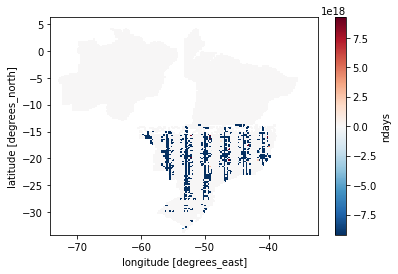

In [18]:
# print(ndaymat.dtype)
# ndayarr.plot()

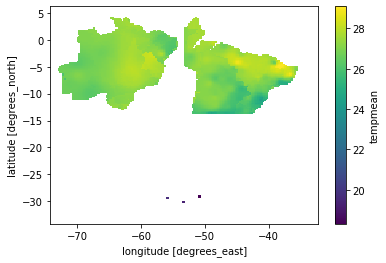

In [23]:
tempmean.plot()

In [9]:
# These plots are good for understanding the distribution of T during the day
# Tl1 = 15
# Tl2 = Tl1 + 1
# l =(np.invert(np.isnan(
#             np.where((T>=Tl1) & (T<=Tl2) ,T,np.nan)
#         )))
# print(np.sum(l)/nt)

# plt.subplot(2, 1, 1)
# plt.plot(t,T)
# plt.axhline(y=Tl1)
# plt.axhline(y=Tl2)
# plt.ylim((10,30))
# plt.subplot(2, 1, 2)
# plt.plot(t,l)
# plt.show()

# Tmin = 15
# Tmax = 25
# Tlo = -5.0
# Thi = 50.0
# Tint = 1.0
# plt.subplot(1, 2, 1)
# plt.plot(t,T,)
# plt.ylim((10,30))
# plt.subplot(1, 2, 2)
# plt.plot(calc_dist_point(Tmin,Tmax,Tlo,Thi,Tint),Tl1s)
# plt.ylim((10,30))
# plt.show()